In [1]:
# === 1. Imports and Environment Setup ===

# --- Standard Libraries ---
import os
import time
import random
import itertools

# --- Numerical and Scientific Libraries ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree

# --- Machine Learning Libraries ---
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- SciANN for PINNs ---
import sciann as sn
from sciann import *

# Import everything from your utility file
from Functions import *


In [2]:
# --- Set Working Directory ---
WORKING_DIR = r'C:\Users\AAR045\OneDrive - Wärtsilä Corporation\Working\Code\2D Elasticity'


# Input file
INP_FILE = "d.inp"

In [3]:
# === Block 1: Load and Parse the Abaqus Input File ===

# Parse the .inp file
nodes, nsets, bc_by_dof = parse_inp_file(INP_FILE)

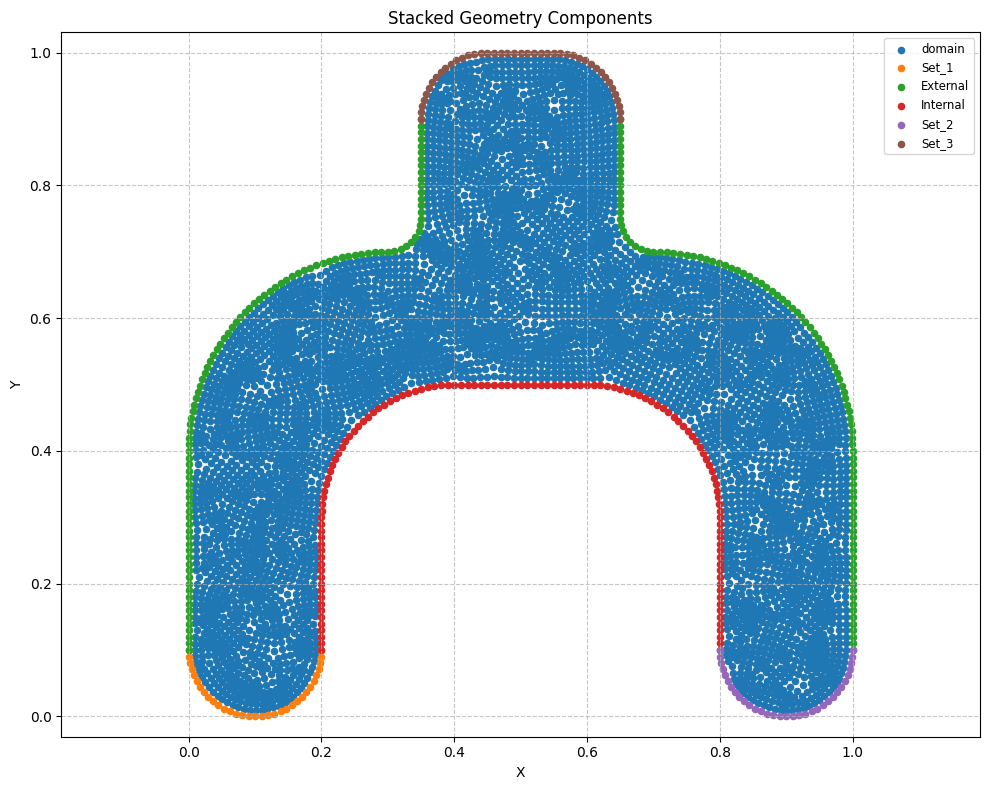

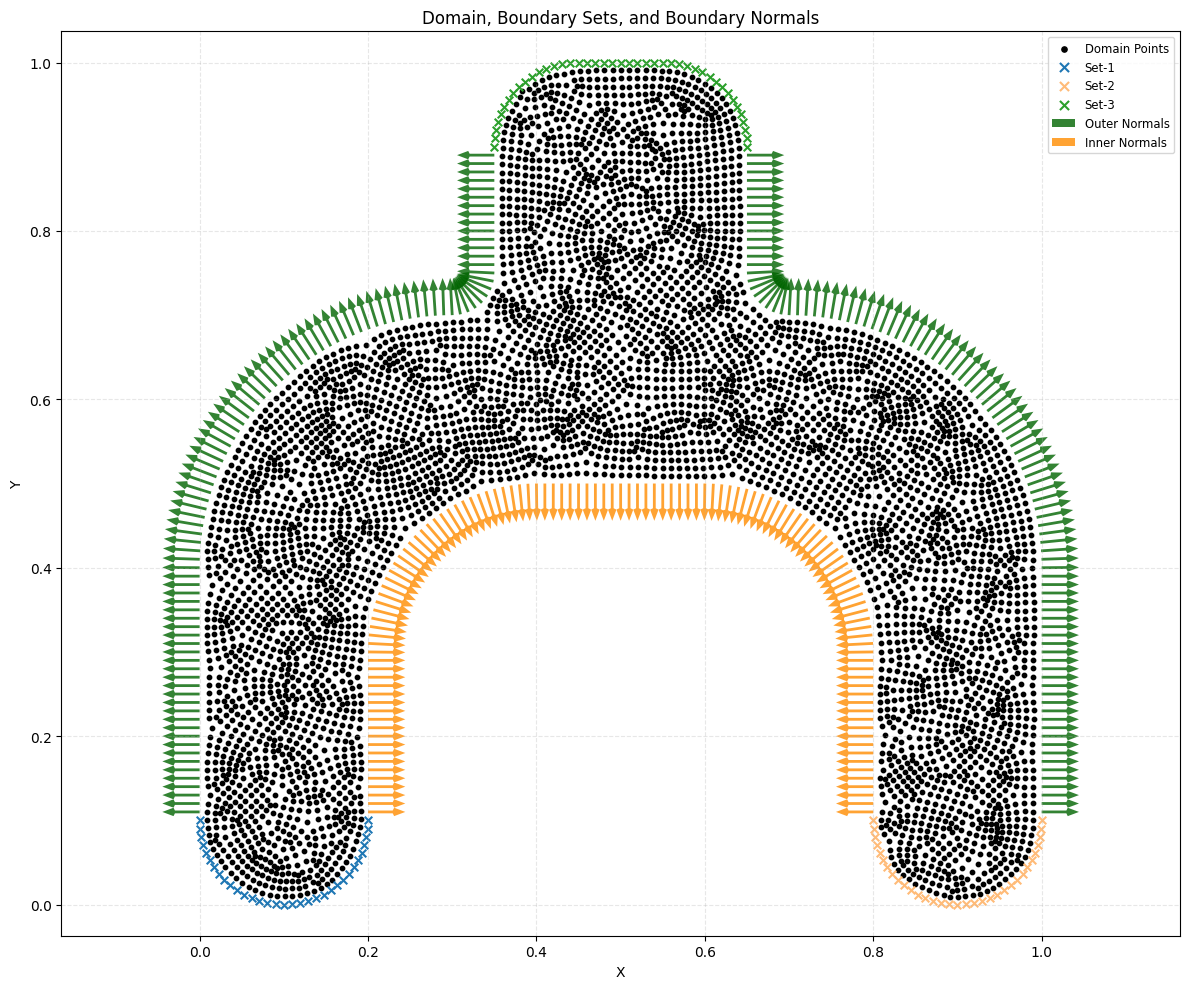

idx_domain: 42 to 5650 (5265 points)
idx_Set_1: 0 to 1458 (33 points)
idx_External: 0 to 5692 (202 points)
idx_Internal: 1458 to 4246 (123 points)
idx_Set_2: 4226 to 5662 (33 points)
idx_Set_3: 1975 to 3766 (43 points)


In [4]:
nset_coords = get_set_coords(nodes, nsets)
domain_points = get_domain_coords(nodes, nset_coords)
stacked_coords, index_arrays = staking_geometry(domain_points, nset_coords)
plot_stacked_coords_custom(stacked_coords, index_arrays)

# Compute normals for external boundary
# Safe version with reordering ON
outer_points_and_normals = traction_normals(nset_coords, boundary_name='External', flip=True, reorder=True)

# Internal boundary normals
inner_points_and_normals = traction_normals(nset_coords, boundary_name='Internal', flip=False, reorder=True)

# For Outer Boundary
nx_outer = outer_points_and_normals[:, 2:3]  # Normal x-component (shape N x 1)
ny_outer = outer_points_and_normals[:, 3:4]  # Normal y-component (shape N x 1)

# For Inner Boundary
nx_inner = inner_points_and_normals[:, 2:3]
ny_inner = inner_points_and_normals[:, 3:4]


plot_geometry_with_normals(domain_points,
                            nset_coords,
                            outer_normals=outer_points_and_normals,
                            inner_normals=inner_points_and_normals)



# Separate x and y inputs
x_input = stacked_coords[:, 0:1]
y_input = stacked_coords[:, 1:2]

# Unpack the indices if you want
idx_domain = index_arrays['idx_domain']
idx_Set_1 = index_arrays['idx_Set_1']
idx_Set_2 = index_arrays['idx_Set_2']
idx_Internal = index_arrays['idx_Internal']
idx_External = index_arrays['idx_External']
idx_Set_3 = index_arrays['idx_Set_3']
# Or print all
for name, idx in index_arrays.items():
    print(f"{name}: {idx[0]} to {idx[-1]} ({len(idx)} points)")


In [5]:
# Quick summary print
print(f"✅ Nodes parsed: {len(nodes)}")
print(f"✅ Node Sets parsed: {len(nsets)}")
print(f"✅ BCs parsed: {sum(len(v) for v in bc_by_dof.values())} total conditions.")
print(f"✅ Nodes stacked: {len(stacked_coords)}")

✅ Nodes parsed: 5693
✅ Node Sets parsed: 5
✅ BCs parsed: 6 total conditions.
✅ Nodes stacked: 5693


In [6]:
applied_displacement = constant_array(3, len(idx_Set_3))


In [7]:
# ===  Build and Train the SciANN Model ===

# --- Define Variables ---
x = sn.Variable('x')
y = sn.Variable('y')

# --- Define Functionals (NN outputs) ---
hidden_layers = 4 * [100]  # 4 hidden layers, 100 neurons each, tanh activation

# Displacements
Uxy = sn.Functional('Uxy', [x, y], hidden_layers, activation='tanh')
Vxy = sn.Functional('Vxy', [x, y], hidden_layers, activation='tanh')

# Stresses
Sxx = sn.Functional('Sxx', [x, y], hidden_layers, activation='tanh')
Syy = sn.Functional('Syy', [x, y], hidden_layers, activation='tanh')
Sxy = sn.Functional('Sxy', [x, y], hidden_layers, activation='tanh')

# --- Define Strain Components ---
Exx = sn.diff(Uxy, x)
Eyy = sn.diff(Vxy, y)
Exy = 0.5 * (sn.diff(Uxy, y) + sn.diff(Vxy, x))

# --- Material Parameters (Linear Elasticity) ---
lmbd = 1.0   # Lamé parameter λ
mu = 0.5     # Shear modulus μ

C11 = 2 * mu + lmbd
C12 = lmbd
C33 = 2 * mu

# --- Constitutive Equations (Hooke's Law) ---
c1 = sn.Tie(Sxx, C11 * Exx + C12 * Eyy, name="c1")
c2 = sn.Tie(Syy, C11 * Eyy + C12 * Exx, name="c2")
c3 = sn.Tie(Sxy, C33 * Exy, name="c3")

# --- PDE Equilibrium Equations ---
Lx = sn.diff(Sxx, x) + sn.diff(Sxy, y)
Ly = sn.diff(Sxy, x) + sn.diff(Syy, y)


# Outer Boundary Traction Equations
Tn_x_outer = Sxx * nx_outer + Sxy * ny_outer
Tn_y_outer = Sxy * nx_outer + Syy * ny_outer

# Inner Boundary Traction Equations
Tn_x_inner = Sxx * nx_inner + Sxy * ny_inner
Tn_y_inner = Sxy * nx_inner + Syy * ny_inner



In [11]:
Targets = [Lx, Ly, c1, c2, c3, Uxy,Uxy,Uxy,Vxy,Vxy,Vxy,Tn_x_inner,Tn_y_inner,Tn_x_outer,Tn_y_outer]

Target_data = [
    (idx_domain, 'zeros'),  # Lx
    (idx_domain, 'zeros'),  # Ly
    (idx_domain, 'zeros'),  # c1
    (idx_domain, 'zeros'),  # c2
    (idx_domain, 'zeros'),  # c3
    (idx_Set_1, 'zeros'),   # Uxy (Set-1)
    (idx_Set_2, 'zeros'),   # Uxy (Set-2)
    (idx_Set_3, applied_displacement),   # Uxy (Set-3)
    (idx_Set_1, 'zeros'),   # Vxy (Set-1)
    (idx_Set_2, 'zeros'),   # Vxy (Set-2)
    (idx_Set_3, applied_displacement),
    (idx_Internal,'zeros'),
    (idx_Internal,'zeros'),
    (idx_External,'zeros'),
    (idx_External,'zeros')
]
# === Build and Train the SciANN Model ===
sn.set_random_seed(42)  # Ensure reproducibility

model = SciModel([x, y], Targets)


# === Train the model with adaptive weighting ===
h = model.train(
    [x_input, y_input],
    Target_data,
    epochs=100,
    shuffle=True,
    verbose=1
)
print("Finally the model is trained")



Total samples: 5693 
Batch size: 64 
Total batches: 89 

Epoch 1/100


InvalidArgumentError: Incompatible shapes: [64] vs. [198]
	 [[{{node training_4/Adam/gradients/gradients/loss_6/add_6_loss/weighted_loss/Mul_grad/Mul}}]]

In [ ]:
# === Block 4: Skipping Prepare Boundary Normals ===

# Process external boundary (normal points outward naturally)
#outer_points_and_normals = prepare_clean_boundary(external_coords, bc_u_coords_sets, bc_v_coords_sets, flip=True)

# Process internal boundary (flip normals to point outward from hole)
#inner_points_and_normals = prepare_clean_boundary(internal_coords, bc_u_coords_sets, bc_v_coords_sets, flip=False)

# Quick check
#print(f"✅ Outer boundary normals shape: {outer_points_and_normals.shape}")
#print(f"✅ Inner boundary normals shape: {inner_points_and_normals.shape}")


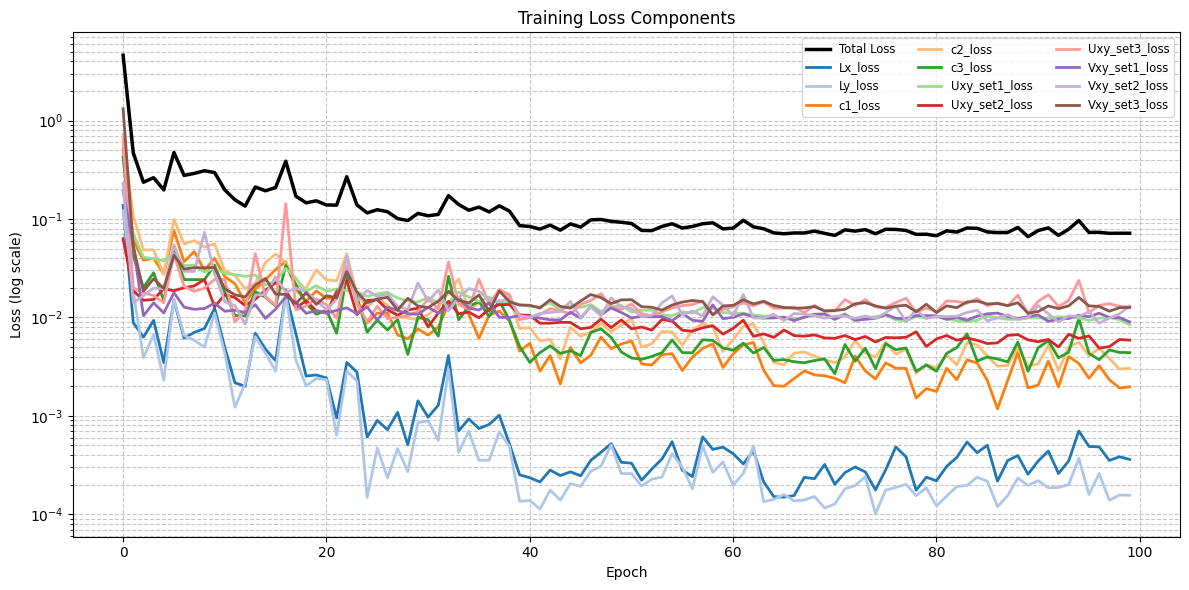

In [ ]:
# === Block 10: Plot Training Loss Components ===

# Define labels for each loss component
target_labels = [
    'Lx', 'Ly',            # PDE residuals
    'c1', 'c2', 'c3',       # Constitutive laws
    'Uxy_set1', 'Uxy_set2','Uxy_set3', # Uxy Dirichlet BCs
    'Vxy_set1', 'Vxy_set2','Vxy_set3'
]

# Plot
plot_training_loss(h, target_labels)


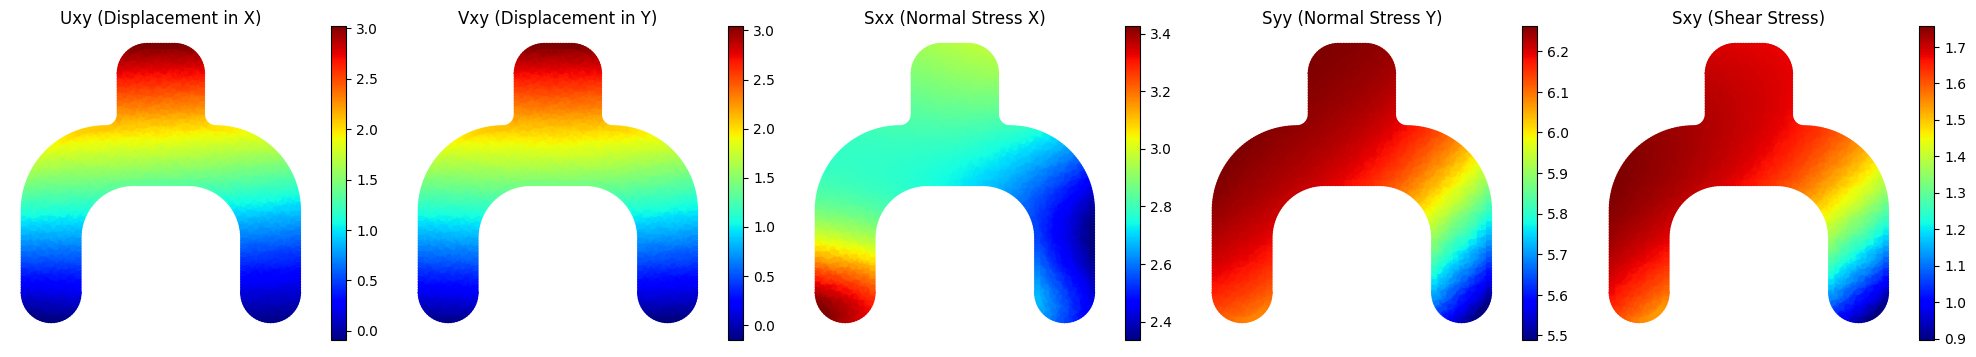

In [ ]:
# === Block 11: Predict and Plot Displacement and Stress Fields ===

# Define which functionals to evaluate
functionals = [Uxy, Vxy, Sxx, Syy, Sxy]

# Define titles for plots
titles = [
    "Uxy (Displacement in X)",
    "Vxy (Displacement in Y)",
    "Sxx (Normal Stress X)",
    "Syy (Normal Stress Y)",
    "Sxy (Shear Stress)"
]

# Predict and plot
evaluate_and_plot_fields(x_input, y_input, functionals, titles)
